# 导入相关模组

In [1]:
import yaml
import pcse
#  import sys
import os
import pickle
import copy
import numpy as np
import pandas as pd

from Wofost_opt import my_crop_dict, my_agro, ModelRerunner
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider, WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from pcse.models import Wofost72_WLP_FD

In [2]:
data_dir = os.path.join(os.getcwd(), "data")

## 2.1 读取作物参数

In [3]:
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)


## 2.2 土壤参数

In [4]:
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

## 2.3 站点数据

In [5]:
# NAVAILI       Amount of N available in the pool at initialization of the system [kg/ha]
sited = WOFOST71SiteDataProvider(WAV=18)
# sited = WOFOST72SiteDataProvider(WAV=18)

## 2.4 合并数据

In [6]:
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

## 2.5 读取管理文件

In [7]:
with open("./data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("./data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

## 2.6 气象数据

In [8]:
weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

# 3 模型运行

In [9]:
# 管理文件数据
agro = my_agro(yaml_agro_2021, 180)

In [10]:
# 参数顺序
parameters_name = ["SLATB001", "SPAN", "EFFTB003", "TMNFTB003", "CVO", "FLTB003", "TDWI", "CVL",
                       "TEFFMX", "EFFTB001", "KDIFTB003"]

In [11]:
param_df = pd.read_csv(os.path.join(data_dir, "opt", "opt1", "opt_ZDN180_result.csv"), index_col=0)
param_df.sort_values(by=['rmse'], ascending=True, inplace=True)
# param_df = param_df[param_df['rmse'] < 0.31]

In [12]:
rows, _ = param_df.shape
modelrerunner = None
modelrerunner = ModelRerunner(parameters, wdp, agro)
for i in range(rows):
    p_value = list()
    for each in parameters_name:
        p_value.append(param_df.iloc[i][each])
    result = modelrerunner(p_value, flag=True)
    if modelrerunner.summary[0]['TWSO'] > 9000 and modelrerunner.summary[0]['TWSO'] < 10000:
        print("%i-%.3f" % (i, modelrerunner.summary[0]['TWSO']))
# print(result[0])
print(modelrerunner.summary[0])

103-9984.061
198-9955.159
354-9933.568
392-9965.869
398-9955.851
418-9992.156
464-9976.701
488-9958.049
515-9976.816
523-9930.528
559-9961.303
560-9917.832
582-9929.070
632-9929.855
670-9854.337
680-9922.295
730-9991.237
735-9964.030
789-9967.841
809-9993.289
810-9973.660
851-9921.944
881-9966.825
912-9976.390
940-9798.914
947-9983.681
955-9875.875
972-9941.905
973-9998.525
989-9962.082
1002-9929.633
1051-9961.098
1057-9954.207
1062-9946.720
1063-9973.011
1069-9944.599
1082-9972.451
1099-9749.670
1119-9974.007
1149-9971.574
1164-9982.444
1182-9990.029
1183-9992.112
1188-9997.433
1189-9936.727
1197-9981.487
1204-9963.658
1244-9955.595
1252-9967.470
1265-9999.700
1280-9963.309
1293-9964.244
1294-9980.983
1305-9995.721
1309-9855.537
1312-9836.357
1313-9972.516
1329-9883.848
1331-9923.370
1336-9949.640
1342-9893.691
1352-9961.645
1364-9916.860
1374-9991.263
1375-9974.153
1386-9740.346
1388-9983.439
1393-9984.493
1402-9978.427
1406-9943.319
1411-9920.736
1421-9936.679
1423-9999.052
1426-999

: 

: 

In [30]:
res_2021 = result[0]

<AxesSubplot:xlabel='day'>

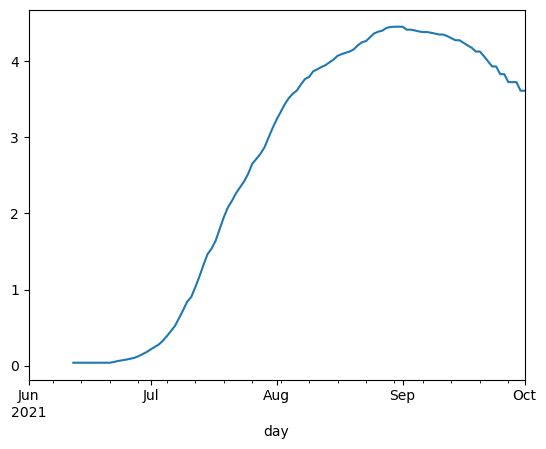

In [31]:
res_2021.LAI.plot()